In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import sys
from meta_model.utils import ndcg_sim, ndcg, custom_sim
sys.path.append("meta_model")

In [2]:
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
df1 = pd.read_csv("meta_dataset_creation/data/meta_features/original/meta_features.csv", index_col="id")
df2 = pd.read_csv("meta_dataset_creation/data/meta_features/from_numeric/meta_features.csv", index_col="id")

meta_X1 = df1.to_numpy()
meta_X2 = df2.to_numpy()
sc = StandardScaler().fit(meta_X1)
scaled_matrix1 = sc.transform(meta_X1)
scaled_matrix2 = sc.transform(meta_X2)
print("Number of meta features1:", meta_X1.shape[1])
print("Number of instances1:", meta_X1.shape[0])
print("Number of meta features2:", meta_X2.shape[1])
print("Number of instances2:", meta_X2.shape[0])
X = TSNE(n_components=2, metric="manhattan", init="pca",
    learning_rate="auto", n_jobs=-1).fit_transform(np.concatenate((scaled_matrix1, scaled_matrix2)))

Number of meta features1: 61
Number of instances1: 100
Number of meta features2: 61
Number of instances2: 500


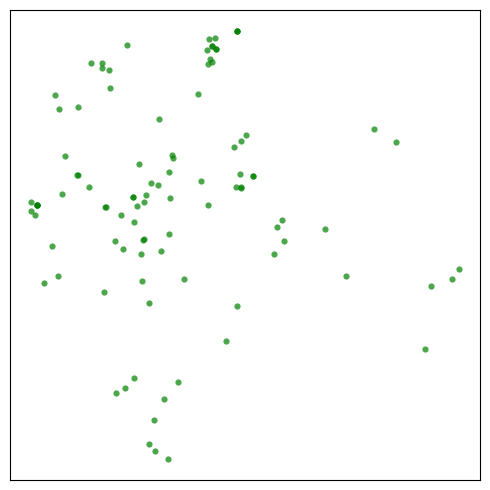

In [4]:
plt.figure(figsize=(5, 5))
plt.scatter(
    X[:meta_X1.shape[0], 0], X[:meta_X1.shape[0], 1], s=20,
    alpha=0.7,
    linewidth=0,
    c="green"
)
indices = np.random.choice(meta_X2.shape[0], size=500, replace=False) + meta_X1.shape[0]
plt.scatter(
    X[indices, 0], X[indices, 1], s=20,
    alpha=0.7,
    linewidth=0,
    c="red"
)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

In [6]:
y1 = np.array([1, 0.95, 0.9, 0.8, 0.7])
y2 = np.array([0.7, 0.9, 0.85, 0.8, 0.7])
ndcg(y1**2, y2**2)

0.9648232225432198

In [7]:
benchmark_results = {}
benchmark_results_dir = "meta_dataset_creation/data/benchmark_results/"
clustering_algorithms = os.listdir(benchmark_results_dir)
clustering_algorithms

['kprototypes', 'haverage']

In [8]:
for algorithm in clustering_algorithms:
    benchmark_results[algorithm] = {}
    for name in os.listdir(os.path.join(benchmark_results_dir, algorithm)):
        benchmark_results[algorithm][name] = {}
        folder_path = os.path.join(benchmark_results_dir, algorithm, name)
        scores_dir = os.path.join(folder_path, "scores/")
        for filename in os.listdir(scores_dir):
            data_id = filename.split('.')[0]
            with open(os.path.join(scores_dir, filename), "rb") as f:
                result = pickle.load(f)
            for sim_pair in result:
                for eval_metric in result[sim_pair]:
                    if eval_metric not in benchmark_results[algorithm][name]:
                        benchmark_results[algorithm][name][eval_metric] = {}
                    if data_id not in benchmark_results[algorithm][name][eval_metric]:
                        benchmark_results[algorithm][name][eval_metric][data_id] = {}
                    benchmark_results[algorithm][name][eval_metric][data_id][sim_pair] = \
                        max([v["score"] for v in result[sim_pair][eval_metric]])
        for eval_metric in benchmark_results[algorithm][name]:
            benchmark_results[algorithm][name][eval_metric] = \
                pd.DataFrame.from_dict(benchmark_results[algorithm][name][eval_metric], orient='index')
            benchmark_results[algorithm][name][eval_metric] = \
                benchmark_results[algorithm][name][eval_metric].fillna(-1)
            max_ = benchmark_results[algorithm][name][eval_metric].max(axis=1)
            # benchmark_results[algorithm][name][eval_metric] = benchmark_results[algorithm][name][eval_metric][max_ > 0.7]
            print(algorithm, name, eval_metric, benchmark_results[algorithm][name][eval_metric].shape)

kprototypes acc (116, 120)
kprototypes ari (116, 120)
kprototypes purity (116, 120)
kprototypes sil (116, 120)
kprototypes acc (84, 120)
kprototypes ari (84, 120)
kprototypes purity (84, 120)
kprototypes sil (84, 120)


In [10]:
algorithm = 'kprototypes'
eval_metric = 'acc'
benchmark_results[algorithm]["original"][eval_metric].head()

,euclidean_hamming,euclidean_eskin,euclidean_iof,euclidean_of,euclidean_jaccard,euclidean_dice,euclidean_kulsinski,euclidean_rogerstanimoto,euclidean_russellrao,euclidean_sokalmichener,...,euclidean_co-oc,manhattan_co-oc,chebyshev_co-oc,sqeuclidean_co-oc,canberra_co-oc,mahalanobis_co-oc,cosine_co-oc,pearson_co-oc,lorentzian_co-oc,divergence_co-oc
339,0.777778,0.777778,0.777778,0.777778,0.666667,0.666667,0.666667,0.583333,0.666667,0.583333,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
346,0.540000,0.540000,0.520000,0.540000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.520000,0.500000,0.620000,0.500000,0.640000,0.640000,0.500000,0.640000
682,0.540230,0.540230,0.540230,0.540230,0.540230,0.540230,0.540230,0.540230,0.540230,0.540230,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1455,0.933333,0.933333,0.908333,0.933333,0.933333,0.933333,0.933333,0.933333,0.916667,0.933333,...,0.908333,0.908333,0.908333,0.900000,0.933333,0.900000,0.583333,-1.000000,0.916667,0.925000
342,0.511628,0.511628,0.558140,0.534884,0.488372,0.488372,0.465116,0.511628,0.488372,0.511628,...,0.558140,0.581395,0.534884,0.534884,0.581395,0.534884,0.581395,0.534884,0.581395,0.627907


In [11]:

benchmark_results[algorithm]["from_numeric"][eval_metric].head()

,euclidean_hamming,euclidean_eskin,euclidean_iof,euclidean_of,euclidean_co-oc,euclidean_jaccard,euclidean_dice,euclidean_kulsinski,euclidean_rogerstanimoto,euclidean_russellrao,...,divergence_iof,divergence_of,divergence_co-oc,divergence_jaccard,divergence_dice,divergence_kulsinski,divergence_rogerstanimoto,divergence_russellrao,divergence_sokalmichener,divergence_sokalsneath
36_1062,0.861111,0.861111,0.861111,0.861111,0.861111,0.861111,0.861111,0.888889,0.861111,0.888889,...,0.861111,0.861111,0.861111,0.861111,0.861111,0.888889,0.833333,0.888889,0.833333,0.861111
288_1517,0.468085,0.468085,0.468085,0.468085,0.468085,0.468085,0.468085,0.468085,0.489362,0.489362,...,0.446809,0.468085,0.531915,0.489362,0.489362,0.510638,0.468085,0.510638,0.468085,0.446809
55_476,0.560000,0.560000,0.560000,0.560000,0.560000,0.560000,0.560000,0.560000,0.560000,0.560000,...,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000
247_476,0.640000,0.640000,0.640000,0.680000,0.800000,0.640000,0.640000,0.640000,0.640000,0.640000,...,0.620000,0.660000,0.800000,0.620000,0.640000,0.620000,0.620000,0.620000,0.620000,0.620000
309_683,0.700000,0.700000,0.716667,0.700000,-1.000000,0.700000,0.700000,0.700000,0.700000,0.700000,...,0.750000,0.716667,-1.000000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000


In [34]:
from sklearn.metrics import pairwise_distances
mixed_Y = benchmark_results[algorithm]["original"][eval_metric].to_numpy()
mixed_Yn = np.array([y/max(y) for y in mixed_Y])
mixed_Yn[mixed_Yn>0] **= 4
mixed_Yn[mixed_Yn<0] = -1

numeric_Y = benchmark_results[algorithm]["from_numeric"][eval_metric].to_numpy()
numeric_Yn = np.array([y/max(y) for y in numeric_Y])
numeric_Yn[numeric_Yn>0] **= 4
numeric_Yn[numeric_Yn<0] = -1

sim_matrix = pairwise_distances(mixed_Yn, metric=lambda y1,y2: ndcg_sim(y1,y2,p=5), n_jobs=-1)
# sim_matrix = pairwise_distances(np.concatenate((mixed_Yn, numeric_Yn)), metric=lambda y1,y2: ndcg_sim(y1,y2,p=5), n_jobs=-1)
# sim_matrix = pairwise_distances(Y, metric=lambda y1,y2: custom_sim(y1,y2), n_jobs=-1)

In [35]:
np.fill_diagonal(sim_matrix, 0)
print(mixed_Yn.shape)
for i, x in enumerate(np.argsort(-sim_matrix[:mixed_Yn.shape[0]], axis=1)[:, :10]):
    print(x, sim_matrix[i][x])

(84, 120)
[49 31  2 12 35 33 29 70 16 56] [0.76603836 0.75938813 0.71990754 0.71217884 0.69230322 0.67534709
 0.67243596 0.65503377 0.64912648 0.64028311]
[16  8 31 34 39 70 29 12 33 72] [0.93437537 0.89881955 0.88572442 0.88208868 0.86591875 0.84251464
 0.83273352 0.81201053 0.80966813 0.74745912]
[ 8 38 48 16  0 34 33  1 78 39] [1.         0.88657594 0.82986345 0.72980864 0.71990754 0.61433268
 0.57627403 0.5641679  0.54284581 0.53364752]
[21 25 54 30 81 35 28 70 31  7] [1.         0.97940597 0.97393505 0.96568362 0.96568362 0.96568362
 0.96568362 0.96368615 0.94845802 0.93046202]
[70 31 35 12  3 73 83 30 28 79] [0.91205086 0.88264375 0.83259831 0.789959   0.78931714 0.76716917
 0.74726273 0.73821295 0.73747919 0.72137217]
[54  7 75 25 50 76 78 77 72 29] [0.77382664 0.72423075 0.61811511 0.60683171 0.6027999  0.60235711
 0.56898659 0.5657383  0.56339515 0.53581083]
[51 79  9 32 22 27 73 39 42 47] [1.         0.99913189 0.99443519 0.99031164 0.88035625 0.83806088
 0.82403973 0.7931310

In [36]:
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
mixed_meta_df = pd.read_csv("meta_dataset_creation/data/meta_features/original/meta_features.csv", index_col="id")
mixed_meta_df.index = mixed_meta_df.index.astype(str)
print("Number of meta features:", mixed_meta_df.shape[1])
print("Number of instances:", mixed_meta_df.shape[0])

Number of meta features: 61
Number of instances: 100


In [37]:
numeric_meta_df = pd.read_csv("meta_dataset_creation/data/meta_features/from_numeric/meta_features.csv", index_col="id")
numeric_meta_df.index = numeric_meta_df.index.astype(str)
print("Number of meta features:", numeric_meta_df.shape[1])
print("Number of instances:", numeric_meta_df.shape[0])

Number of meta features: 61
Number of instances: 500


In [39]:
mixed_X = mixed_meta_df.loc[benchmark_results[algorithm]["original"][eval_metric].index].to_numpy()
sc = StandardScaler().fit(mixed_X)
mixed_X = sc.transform(mixed_X)

numeric_X = numeric_meta_df.loc[benchmark_results[algorithm]["from_numeric"][eval_metric].index].to_numpy()
numeric_X = sc.transform(numeric_X)
numeric_X.shape

mixed_X.shape, numeric_X.shape

((84, 61), (116, 61))

In [52]:
D = pairwise_distances(mixed_X)
k = 10
conformity = []
for i, sim_vec in enumerate(sim_matrix):
    dist_vec = D[i]
    nearest_neighbors1 = set([j for j in np.argsort(-sim_vec) if j != i][:k])
    nearest_neighbors2 = set([j for j in np.argsort(dist_vec) if j != i][:k])
    conformity.append(len(nearest_neighbors1.intersection(nearest_neighbors2))/k)

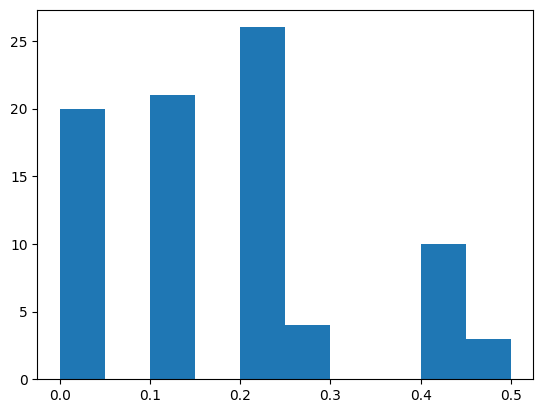

In [53]:
import matplotlib.pyplot as plt
plt.hist(conformity)
plt.show()

In [17]:
from meta_model.utils import ndcg
k = 3
ndcg1 = []
ndcg2 = []
d_neighbors = []
for i, y in enumerate(Yrn):
    sim_vec = sim_matrix[i]
    dist_vec = D[i]
    nearest_neighbors1 = [j for j in np.argsort(-sim_vec) if j != i][:k]
    nearest_neighbors2 = [j for j in np.argsort(dist_vec) if j != i][:k]
    d_neighbors.append(np.mean(dist_vec[nearest_neighbors2]))

    # n1 = np.mean(ndcg([y], Yrn[nearest_neighbors1]))
    # n2 = np.mean(ndcg([y], Yrn[nearest_neighbors2]))
    # ndcg1.append(n1)
    # ndcg2.append(n2)

    y1 = np.sum(Yrn[nearest_neighbors1], axis=0)
    y2 = np.sum(Yrn[nearest_neighbors2], axis=0)
    ndcg1.append(ndcg(y, y1, p=5))
    ndcg2.append(ndcg(y, y2, p=5))
print(list(zip(ndcg1, ndcg2)))

[(0.8557687743918049, 0.6480528980803595), (1.0, 0.39399015310297936), (1.0, 0.37651859567901236), (1.0, 0.9316497791161635), (1.0, 0.494443893065668), (0.6131594356976694, 0.4102549680954501), (1.0, 0.6560146484957975), (0.9764154839515239, 0.4124453300871124), (1.0, 0.422023870222485), (0.9910235284093883, 0.694814278596912), (1.0, 0.44502672660982623), (0.872839137455879, 0.4796714597408522), (0.8727778637436946, 0.48252030457119516), (1.0, 0.39768516301289486), (0.9909443055076991, 0.9031622972857), (0.9782626208551293, 0.5106433256817472), (0.9771190028146978, 0.8250439239012343), (0.8860039486738084, 0.7379325395365917), (0.9536541383419869, 0.6520735428579051), (0.9258761644763401, 0.9186867937393604), (0.8975901442987861, 0.6729629088436374), (1.0, 0.9313145779397507), (0.9639442308096615, 0.8838435605155586), (0.8972642336740199, 0.4479575381266049), (0.8612242493603995, 0.617150785940491), (0.979405968542632, 0.18567522557097227), (0.8425000572215962, 0.537536551557814), (0.8

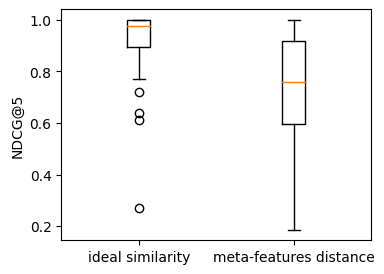

In [18]:
plt.figure(figsize=(4, 3))
plt.boxplot([ndcg1, ndcg2], labels=["ideal similarity", "meta-features distance"])
plt.ylabel("NDCG@5")
plt.show()

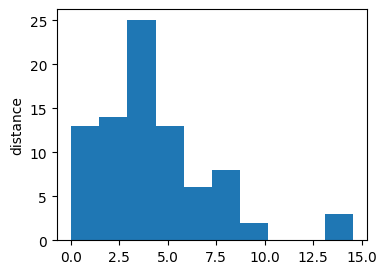

In [19]:
plt.figure(figsize=(4, 3))
plt.hist(d_neighbors, bins=10)
plt.ylabel("distance")
plt.show()

2


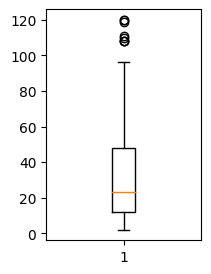

In [20]:
best_pairs = [[j for j, yj in enumerate(y) if yj/max(y) > .95] for y in Y]
print(min([len(l) for l in best_pairs]))
plt.figure(figsize=(2, 3))
plt.boxplot([[len(l) for l in best_pairs]])
plt.show()

In [21]:
D = pairwise_distances(X)
k = 100
conformity = []
for i, dist_vec in enumerate(D):
    nearest_neighbors = [j for j in np.argsort(dist_vec) if j != i][:k]
    sim_neighbors = sim_matrix[i][nearest_neighbors]
    print(sum(sim_neighbors > 0.8))

0
9
3
18
3
0
7
11
5
9
2
0
8
1
14
2
1
0
3
15
1
13
13
0
0
12
7
6
13
22
13
23
7
1
9
12
9
1
8
5
2
0
8
0
0
1
3
3
3
1
13
6
3
2
11
3
11
3
2
3
0
11
2
6
6
4
6
6
6
6
15
5
9
20
9
5
0
13
12
26
5
8
13
9


In [62]:
selected_datasets = [i for i in range(X.shape[0]) if np.mean(sorted(sim_matrix[i], reverse=True)[:3])>0.8] # if np.mean(sorted(sim_matrix[i], reverse=True)[:3])>0.6
print(len(selected_datasets))
mixed_X = X[selected_datasets]
newY = Y[selected_datasets]
newYrn = Yrn[selected_datasets]

68


In [40]:
def accept(y1, y2, t):
    if y2 <= y1:
        p = 1
    else:
        p = 0 if t==0 else np.exp((y1 - y2)/t)
    return np.random.random() <= p
    
def heating(fitness, sample_generator, update, N=100, alpha=1.1, c0=0.8):
    def f(t):
        x1 = sample_generator()
        x2 = update(x1)
        y1, y2 = fitness(x1), fitness(x2)
        return 1 if accept(y1, y2, t) else 0

    t = 0
    for _ in range(10):
        x1 = sample_generator()
        x2 = update(x1)
        t += abs(fitness(x2) - fitness(x1))/10
        
    p_accept = 0
    while p_accept < c0:
        p_accept = 0
        for _ in range(N):
            p_accept += f(t)/N
        t = alpha*t
    return t

def cooling(fitness, sample_generator, update, t0, N=300, alpha=0.99, tf=1e-4, save_search=False):
    x1 = sample_generator()
    y1 = fitness(x1)
    best_x, best_y = x1, y1
    if save_search:
        search_history = {'temperature':[], 'best_y':[], 'y':[]}
    iter = 0
    n_iter_wt_improvement = 0
    t = t0
    while t > t0*tf and n_iter_wt_improvement < 10:
        imp = False
        if save_search:
            search_history['temperature'].append(t)
        for _ in range(N):
            x2 = update(x1)
            y2 = fitness(x2)
            if accept(y1, y2, t):
                x1, y1 = x2, y2
            if y2 < best_y:
                best_y = y2
                best_x = x2
                imp = True
        
        if save_search:
            search_history['best_y'].append(best_y)
            search_history['y'].append(y1)

        t = alpha*t
        iter += 1
        if not imp: 
            n_iter_wt_improvement += 1
        print("iteration: {}, best_y: {:.2f}".format(iter, best_y))
    if save_search:
        return best_x, best_y, search_history
    return best_x, best_y

In [42]:
def select_features(X, Y, k=5):
    def fitness(x):
        s = 0
        D = pairwise_distances(X[:, x>0], n_jobs=-1)
        for i, dist_vec in enumerate(D):
            neighbors = [j for j in np.argsort(dist_vec) if j != i][:k]
            s += ndcg(Y[i], np.mean(Y[neighbors], axis=0))
        return -s/X.shape[0]

    def sample_generator():
        return np.random.randint(2, size=X.shape[1])

    def update(x):
        indices = np.random.randint(X.shape[1], size=np.random.randint(5))
        new_x = np.array(x)
        new_x[indices] = 1 - new_x[indices]
        return new_x

    t0 = heating(fitness, sample_generator, update)
    print("t0: {}".format(t0))
    best_x, best_y, search_history = cooling(fitness, sample_generator, update, t0, alpha=0.99, save_search=True)
    print("best_x: {} best_y: {:.2f}".format(best_x, best_y))
    import matplotlib.pyplot as plt
    plt.plot(search_history["y"])
    plt.show()
    return best_x, best_y
best_x, best_y = select_features(mixed_X, mixed_Y)

In [59]:
from meta_model.utils import ndcg
from meta_model.ranking import ALL_MODELS
from meta_model.ranking_tree import RankingTree
from sklearn.model_selection import KFold

models = {
    "ElasticNet": ALL_MODELS["ElasticNet"](),
    "KNN": ALL_MODELS["KNN"](),
    "DTree": ALL_MODELS["DTree"](),
    "ElasticNet2": ALL_MODELS["ElasticNet"](),
    "KNN2": ALL_MODELS["KNN"](),
    "DTree2": ALL_MODELS["DTree"](),
    # "RT": RankingTree(rank_sim='kendall', min_samples_split=5)
}
predictions = {model_name: np.zeros(shape=newY.shape) for model_name in models}
predictions["AR"] = np.zeros(shape=newY.shape)
i = 0
for train_index, test_index in KFold(n_splits=10, shuffle=True, random_state=0).split(newX):
    print(i, "---------------------------------------")
    # train_index = [j for j in range(X.shape[0]) if i != j]
    # test_index = [i]
    X_train, X_test = newX[train_index], newX[test_index]
    Y_trainr, Y_testr = newY[train_index], newY[test_index]
    for model_name in models:
        print()
        print(f"Training of model: {model_name}")
        if model_name in ["RT"]:
            models[model_name] = models[model_name].fit(X_train[:, best_x>0] if model_name[-1]=='2' else X_train, Y_trainr) #
        else:
            models[model_name] = models[model_name].cross_val_fit(X_train[:, best_x>0] if model_name[-1]=='2' else X_train, Y_trainr, n_splits=5) #
            print(models[model_name].get_params())
        predictions[model_name][test_index] = models[model_name].predict(X_test[:, best_x>0] if model_name[-1]=='2' else X_test)

    predictions["AR"][test_index] = np.array([
        [np.mean([v for v in Y_trainr[:, j] if v > 0]) for j in range(Y_trainr.shape[1])]
        for _ in Y_testr
    ])
    i += 1

0 ---------------------------------------

Training of model: ElasticNet


{'alpha': 0.4, 'l1_ratio': 0.4}

Training of model: KNN
{'metric': 'manhattan', 'n_neighbors': 30, 'weights': 'distance'}

Training of model: DTree
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1}

Training of model: ElasticNet2
{'alpha': 0.4, 'l1_ratio': 0.4}

Training of model: KNN2
{'metric': 'cosine', 'n_neighbors': 30, 'weights': 'distance'}

Training of model: DTree2
{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5}
1 ---------------------------------------

Training of model: ElasticNet
{'alpha': 0.1, 'l1_ratio': 1.0}

Training of model: KNN
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

Training of model: DTree
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5}

Training of model: ElasticNet2
{'alpha': 0.4, 'l1_ratio': 0.4}

Training of model: KNN2
{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}

Training of model: DTree2
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1}
2 ---------------

In [25]:
import torch
import torch.nn as nn
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
print("device:", device)

device: cuda:0


In [26]:
from metric_learning import ContrastiveML
import ranking
from sklearn.metrics import pairwise_distances

class MetaModel():
    def __init__(self, mapping_function=None, ranking_model="KNN", margin=1, gamma=0, device="cpu"):
        self.metric_learner = None if mapping_function is None else \
            ContrastiveML(mapping_function, margin, gamma=gamma)
        self.ranker = ranking.ALL_MODELS[ranking_model]()
        self.device = device

    def _create_similarity_matrix(self, Y1, Y2=None):
        return pairwise_distances(Y1, Y2, metric=lambda y1,y2: ndcg_sim(y1,y2,p=5), n_jobs=-1)
        # return pairwise_distances(Y1, Y2, metric=lambda y1, y2: custom_sim(y1, y2), n_jobs=-1)

    # def train_metric_learner(self, Xtrain, Ytrain, metric_learning_params, Xtest=None, Ytest=None):
    #     if self.metric_learner is None:
    #         return self
    #     sim_matrix = self._create_similarity_matrix(Ytrain)
    #     X1, X2, y = [], [], []
    #     for i in range(Xtrain.shape[0]-1):
    #         for j in range(i+1, Xtrain.shape[0]):
    #             X1.append(Xtrain[i])
    #             X2.append(Xtrain[j])
    #             similar = sim_matrix[i, j] > 0.95
    #             y.append(0 if similar else 1)
    #     X1, X2, y = np.array(X1), np.array(X2), np.array(y)
    #     print()
    #     print("classes distribution in train set:", np.unique(y, return_counts=True))
    #     train_dataset = torch.utils.data.TensorDataset(
    #         torch.tensor(X1, device=self.device).float(),
    #         torch.tensor(X2, device=self.device).float(),
    #         torch.tensor(y, device=self.device).float()
    #     )
    #     test_dataset = None
    #     if Xtest is not None:
    #         sim_matrix = self._create_similarity_matrix(Ytest, Ytrain)
    #         X1, X2, y = [], [], []
    #         for i in range(Xtest.shape[0]):
    #             for j in range(Xtrain.shape[0]):
    #                 X1.append(Xtest[i])
    #                 X2.append(Xtrain[j])
    #                 similar = sim_matrix[i, j] > 0.95
    #                 y.append(0 if similar else 1)
    #         X1, X2, y = np.array(X1), np.array(X2), np.array(y)
    #         print()
    #         print("classes distribution in test set:", np.unique(y, return_counts=True))
    #         test_dataset = torch.utils.data.TensorDataset(
    #             torch.tensor(X1, device=self.device).float(),
    #             torch.tensor(X2, device=self.device).float(),
    #             torch.tensor(y, device=self.device).float()
    #         )
        
    #     self.metric_learner.to(self.device)
    #     optimizer = torch.optim.Adam(self.metric_learner.parameters(), lr=metric_learning_params["lr"])
    #     metric_learning_params.pop("lr")
    #     self.metric_learner.fit(train_dataset, optimizer, test_dataset=test_dataset, **metric_learning_params)
    #     return self

    # def train_metric_learner(self, Xtrain, Ytrain, metric_learning_params, Xtest=None, Ytest=None):
    #     if self.metric_learner is None:
    #         return self
    #     sim_matrix = self._create_similarity_matrix(Ytrain)
    #     d = pairwise_distances(Xtrain)
    #     np.fill_diagonal(d, np.inf)
    #     k = 25
    #     nearest_neighbors = np.argsort(d, axis=1)[:, :k]
    #     X1, X2, y = [], [], []
    #     for i in range(Xtrain.shape[0]):
    #         l = [j for j in np.argsort(-sim_matrix[i]) if j in nearest_neighbors[i]][:5]
    #         for j in nearest_neighbors[i]:
    #             if j in l:
    #                 X1.append(Xtrain[i])
    #                 X2.append(Xtrain[j])
    #                 y.append(0)
    #             elif sim_matrix[i, j] < 0.95:
    #                 X1.append(Xtrain[i])
    #                 X2.append(Xtrain[j])
    #                 y.append(1)

    #     X1, X2, y = np.array(X1), np.array(X2), np.array(y)
    #     print()
    #     print("classes distribution in train set:", np.unique(y, return_counts=True))
    #     train_dataset = torch.utils.data.TensorDataset(
    #         torch.tensor(X1, device=self.device).float(),
    #         torch.tensor(X2, device=self.device).float(),
    #         torch.tensor(y, device=self.device).float()
    #     )
    #     test_dataset = None
    #     if Xtest is not None:
    #         sim_matrix = self._create_similarity_matrix(Ytest, Ytrain)
    #         d = pairwise_distances(Xtest, Xtrain)
    #         nearest_neighbors = np.argsort(d, axis=1)[:, :k]
    #         X1, X2, y = [], [], []
    #         for i in range(Xtest.shape[0]):
    #             l = [j for j in np.argsort(-sim_matrix[i]) if j in nearest_neighbors[i]][:5]
    #             for j in nearest_neighbors[i]:
    #                 if j in l:
    #                     X1.append(Xtest[i])
    #                     X2.append(Xtrain[j])
    #                     y.append(0)
    #                 elif sim_matrix[i, j] < 0.95:
    #                     X1.append(Xtest[i])
    #                     X2.append(Xtrain[j])
    #                     y.append(1)
    #         X1, X2, y = np.array(X1), np.array(X2), np.array(y)
    #         print()
    #         print("classes distribution in test set:", np.unique(y, return_counts=True))
    #         test_dataset = torch.utils.data.TensorDataset(
    #             torch.tensor(X1, device=self.device).float(),
    #             torch.tensor(X2, device=self.device).float(),
    #             torch.tensor(y, device=self.device).float()
    #         )
        
    #     self.metric_learner.to(self.device)
    #     optimizer = torch.optim.Adam(self.metric_learner.parameters(), lr=metric_learning_params["lr"])
    #     metric_learning_params.pop("lr")
    #     self.metric_learner.fit(train_dataset, optimizer, test_dataset=test_dataset, **metric_learning_params)
    #     return self

    def train_metric_learner(self, Xtrain, Ytrain, metric_learning_params, Xtest=None, Ytest=None):
        if self.metric_learner is None:
            return self
        sim_matrix = self._create_similarity_matrix(Ytrain)
        np.fill_diagonal(sim_matrix, 0)
        nearest_neighbors = np.argsort(-sim_matrix, axis=1)
        X1, X2, y = [], [], []
        k = 5
        for i in range(Xtrain.shape[0]):
            for j in range(Xtrain.shape[0]):
                if j != i:
                    if j in nearest_neighbors[i][:k]:
                        X1.append(Xtrain[i])
                        X2.append(Xtrain[j])
                        y.append(0)
                    elif sim_matrix[i, j] < .9:
                        X1.append(Xtrain[i])
                        X2.append(Xtrain[j])
                        y.append(1)
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        print()
        print("classes distribution in train set:", np.unique(y, return_counts=True))
        train_dataset = torch.utils.data.TensorDataset(
            torch.tensor(X1, device=self.device).float(),
            torch.tensor(X2, device=self.device).float(),
            torch.tensor(y, device=self.device).float()
        )
        test_dataset = None
        if Xtest is not None:
            sim_matrix = self._create_similarity_matrix(Ytest, Ytrain)
            nearest_neighbors = np.argsort(-sim_matrix, axis=1)
            X1, X2, y = [], [], []
            for i in range(Xtest.shape[0]):
                for j in range(Xtrain.shape[0]):
                    if j in nearest_neighbors[i][:k]:
                        X1.append(Xtest[i])
                        X2.append(Xtrain[j])
                        y.append(0)
                    elif sim_matrix[i, j] < .9:
                        X1.append(Xtest[i])
                        X2.append(Xtrain[j])
                        y.append(1)
            X1, X2, y = np.array(X1), np.array(X2), np.array(y)
            print()
            print("classes distribution in test set:", np.unique(y, return_counts=True))
            test_dataset = torch.utils.data.TensorDataset(
                torch.tensor(X1, device=self.device).float(),
                torch.tensor(X2, device=self.device).float(),
                torch.tensor(y, device=self.device).float()
            )
        
        self.metric_learner.to(self.device)
        optimizer = torch.optim.Adam(self.metric_learner.parameters(), lr=metric_learning_params["lr"])
        metric_learning_params.pop("lr")
        self.metric_learner.fit(train_dataset, optimizer, test_dataset=test_dataset, **metric_learning_params)
        return self

    def embbed(self, X):
        if self.metric_learner is None:
            return X
        with torch.no_grad():
            Z = self.metric_learner(torch.tensor(X, device=self.device).float()).cpu().detach().numpy()
        return Z

    def train_ranker(self, Ztrain, Ytrain):
        self.ranker = self.ranker.cross_val_fit(Ztrain, Ytrain)
        return self


    def fit(self, Xtrain, Ytrain, metric_learning_params, Xtest=None, Ytest=None):
        self.train_metric_learner(Xtrain, Ytrain, metric_learning_params, Xtest=Xtest, Ytest=Ytest)
        Ztrain = self.embbed(Xtrain)
        self.train_ranker(Ztrain, Ytrain)
        return self

    def predict(self, X):
        return self.ranker.predict(self.embbed(X))

In [27]:
from sklearn.manifold import TSNE

Xemb = TSNE(n_components=2).fit_transform(newX)

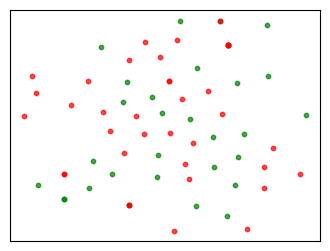

In [28]:
sim_pair = 69
good = [i for i, y in enumerate(newY) if y[sim_pair]/max(y) > .95]
bad = [i for i, y in enumerate(newY) if i not in good]
labels = [1 if y[sim_pair]/max(y) > .95 else 0 for y in newY]
plt.figure(figsize=(4, 3))
plt.scatter(Xemb[good, 0], Xemb[good, 1], s=10, c="green", alpha=0.7)
plt.scatter(Xemb[bad, 0], Xemb[bad, 1], s=10, c="red", alpha=0.7)
plt.xticks([])
plt.yticks([])
plt.show()

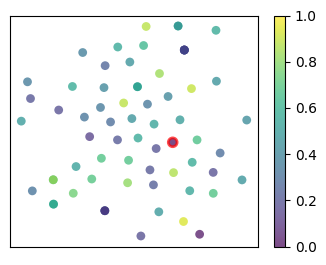

In [29]:
i = 0
plt.figure(figsize=(4, 3))
plt.scatter(
    Xemb[:, 0], Xemb[:, 1], c=sim_matrix[selected_datasets][:,selected_datasets][i], s=40, alpha=0.7,
    edgecolors=['none' if k!=i else "red" for k in range(Xemb.shape[0])],
    linewidth=[0 if k!=i else 2 for k in range(Xemb.shape[0])],
    vmin=0, vmax=1
)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

In [30]:
np.random.seed(0)
train_index = np.random.choice(newX.shape[0], size=int(0.9*newX.shape[0]), replace=False)
test_index = [i for i in range(newX.shape[0]) if i not in train_index]
X_train, X_test = newX[train_index], newX[test_index]
Y_trainr, Y_testr = newY[train_index], newY[test_index]
Y_trainrn, Y_testrn = newYrn[train_index], newYrn[test_index]
embeddings = [Xemb]
network = nn.Sequential(
    nn.Linear(X.shape[1], 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 4)
)
network.to(device)
model = MetaModel(network, margin=1, device=device, gamma=1e-2)
for i in range(1):
    metric_learning_params = {
        "lr": 1e-3,
        "epochs": 100,
        "batch_size": 32
    }
    model.train_metric_learner(
        X_train, Y_trainrn,
        metric_learning_params,
        Xtest=X_test, Ytest=Y_testrn
    )
    # embeddings.append(model.embbed(newX))
    embeddings.append(TSNE(n_components=2).fit_transform(model.embbed(newX)))


classes distribution in train set: (array([0, 1]), array([ 305, 3317]))

classes distribution in test set: (array([0, 1]), array([ 35, 390]))
Epoch 1/100	-	train:  loss=0.35, dist_sim=0.5, dist_dissim=0.55	-	
test:  loss=0.21, dist_sim=0.63, dist_dissim=0.9
Epoch 2/100	-	train:  loss=0.18, dist_sim=0.74, dist_dissim=0.9	-	
test:  loss=0.16, dist_sim=0.59, dist_dissim=0.87
Epoch 3/100	-	train:  loss=0.16, dist_sim=0.73, dist_dissim=0.92	-	
test:  loss=0.15, dist_sim=0.57, dist_dissim=0.84
Epoch 4/100	-	train:  loss=0.15, dist_sim=0.72, dist_dissim=0.93	-	
test:  loss=0.14, dist_sim=0.6, dist_dissim=0.89
Epoch 5/100	-	train:  loss=0.14, dist_sim=0.71, dist_dissim=0.92	-	
test:  loss=0.14, dist_sim=0.63, dist_dissim=0.94
Epoch 6/100	-	train:  loss=0.14, dist_sim=0.71, dist_dissim=0.93	-	
test:  loss=0.14, dist_sim=0.63, dist_dissim=0.97
Epoch 7/100	-	train:  loss=0.14, dist_sim=0.72, dist_dissim=0.95	-	
test:  loss=0.14, dist_sim=0.62, dist_dissim=0.9
Epoch 8/100	-	train:  loss=0.14, dis

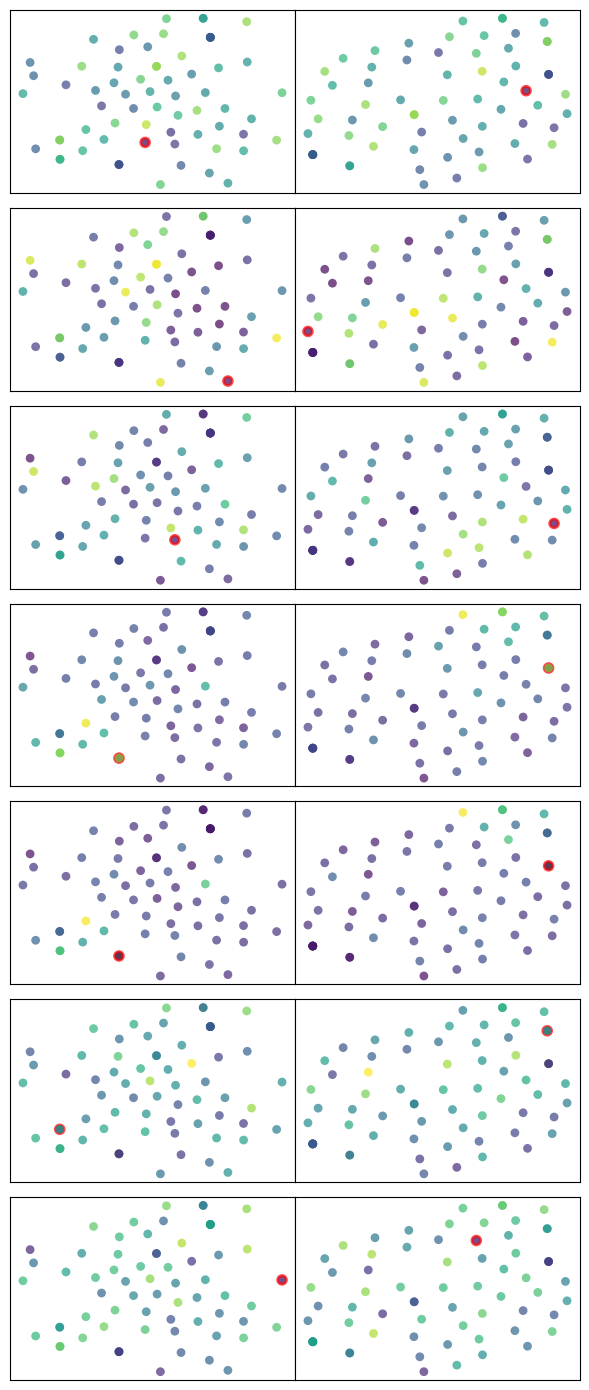

In [31]:
rows, cols = len(test_index), len(embeddings)
plt.figure(figsize=(cols*3, rows*2))
for i, ind in enumerate(test_index):
    for j, Z in enumerate(embeddings):
        plt.subplot(rows, cols, i*cols + j + 1)
        plt.scatter(
            Z[:, 0], Z[:, 1], c=sim_matrix[selected_datasets][:, selected_datasets][ind], s=40, alpha=0.7, 
            edgecolors=['none' if k!=ind else "red" for k in range(Z.shape[0])],
            linewidth=[0 if k!=ind else 2 for k in range(Z.shape[0])],
            vmin=0., vmax=1)
        # plt.colorbar()
        plt.xticks([])
        plt.yticks([])
plt.tight_layout(w_pad=0)
plt.show()

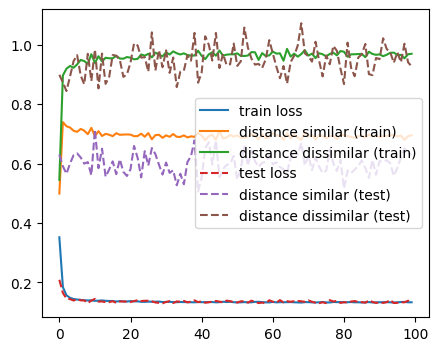

In [34]:
plt.figure(figsize=(5, 4))
plt.plot(model.metric_learner.history["train"]["loss"], label="train loss")
plt.plot(model.metric_learner.history["train"]["distance_similar"], label="distance similar (train)")
plt.plot(model.metric_learner.history["train"]["distance_dissimilar"], label="distance dissimilar (train)")
plt.plot(model.metric_learner.history["test"]["loss"], "--", label="test loss")
plt.plot(model.metric_learner.history["test"]["distance_similar"], "--", label="distance similar (test)")
plt.plot(model.metric_learner.history["test"]["distance_dissimilar"], "--", label="distance dissimilar (test)")
plt.legend()
plt.show()

0 ---------------------------------------



classes distribution in train set: (array([0, 1]), array([ 305, 3322]))

classes distribution in test set: (array([0, 1]), array([ 35, 387]))
Epoch 1/50	-	train:  loss=0.32, dist_sim=0.58, dist_dissim=0.7	-	
test:  loss=0.23, dist_sim=0.68, dist_dissim=0.79
Epoch 2/50	-	train:  loss=0.18, dist_sim=0.74, dist_dissim=0.9	-	
test:  loss=0.17, dist_sim=0.7, dist_dissim=0.86
Epoch 3/50	-	train:  loss=0.16, dist_sim=0.75, dist_dissim=0.92	-	
test:  loss=0.15, dist_sim=0.73, dist_dissim=0.89
Epoch 4/50	-	train:  loss=0.15, dist_sim=0.75, dist_dissim=0.93	-	
test:  loss=0.15, dist_sim=0.72, dist_dissim=0.88
Epoch 5/50	-	train:  loss=0.14, dist_sim=0.73, dist_dissim=0.93	-	
test:  loss=0.15, dist_sim=0.67, dist_dissim=0.82
Epoch 6/50	-	train:  loss=0.14, dist_sim=0.73, dist_dissim=0.94	-	
test:  loss=0.14, dist_sim=0.75, dist_dissim=0.89
Epoch 7/50	-	train:  loss=0.14, dist_sim=0.74, dist_dissim=0.94	-	
test:  loss=0.15, dist_sim=0.76, dist_dissim=0.89
Epoch 8/50	-	train:  loss=0.14, dist_sim=

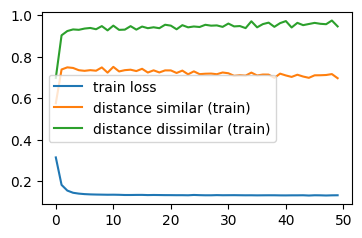

1 ---------------------------------------

classes distribution in train set: (array([0, 1]), array([ 305, 3337]))

classes distribution in test set: (array([0, 1]), array([ 35, 389]))
Epoch 1/50	-	train:  loss=0.32, dist_sim=0.57, dist_dissim=0.69	-	
test:  loss=0.23, dist_sim=0.84, dist_dissim=0.91
Epoch 2/50	-	train:  loss=0.19, dist_sim=0.71, dist_dissim=0.93	-	
test:  loss=0.18, dist_sim=0.77, dist_dissim=0.87
Epoch 3/50	-	train:  loss=0.16, dist_sim=0.69, dist_dissim=0.95	-	
test:  loss=0.17, dist_sim=0.81, dist_dissim=0.92
Epoch 4/50	-	train:  loss=0.15, dist_sim=0.68, dist_dissim=0.95	-	
test:  loss=0.16, dist_sim=0.85, dist_dissim=0.99
Epoch 5/50	-	train:  loss=0.14, dist_sim=0.7, dist_dissim=0.97	-	
test:  loss=0.16, dist_sim=0.8, dist_dissim=0.93
Epoch 6/50	-	train:  loss=0.14, dist_sim=0.69, dist_dissim=0.98	-	
test:  loss=0.16, dist_sim=0.76, dist_dissim=0.91
Epoch 7/50	-	train:  loss=0.14, dist_sim=0.68, dist_dissim=0.98	-	
test:  loss=0.16, dist_sim=0.94, dist_dissim=1.1

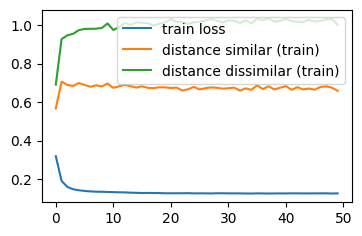

2 ---------------------------------------

classes distribution in train set: (array([0, 1]), array([ 305, 3325]))

classes distribution in test set: (array([0, 1]), array([ 35, 385]))
Epoch 1/50	-	train:  loss=0.34, dist_sim=0.53, dist_dissim=0.6	-	
test:  loss=0.23, dist_sim=0.74, dist_dissim=0.89
Epoch 2/50	-	train:  loss=0.19, dist_sim=0.76, dist_dissim=0.89	-	
test:  loss=0.23, dist_sim=0.79, dist_dissim=1
Epoch 3/50	-	train:  loss=0.16, dist_sim=0.77, dist_dissim=0.93	-	
test:  loss=0.16, dist_sim=0.72, dist_dissim=0.92
Epoch 4/50	-	train:  loss=0.15, dist_sim=0.76, dist_dissim=0.93	-	
test:  loss=0.16, dist_sim=0.76, dist_dissim=0.94
Epoch 5/50	-	train:  loss=0.15, dist_sim=0.74, dist_dissim=0.93	-	
test:  loss=0.16, dist_sim=0.84, dist_dissim=1
Epoch 6/50	-	train:  loss=0.14, dist_sim=0.75, dist_dissim=0.95	-	
test:  loss=0.16, dist_sim=0.78, dist_dissim=0.97
Epoch 7/50	-	train:  loss=0.14, dist_sim=0.74, dist_dissim=0.95	-	
test:  loss=0.17, dist_sim=0.87, dist_dissim=1
Epoch 

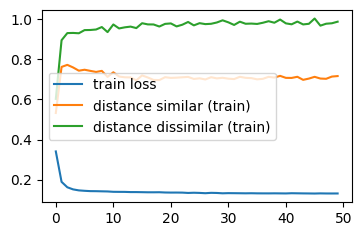

3 ---------------------------------------

classes distribution in train set: (array([0, 1]), array([ 305, 3315]))

classes distribution in test set: (array([0, 1]), array([ 35, 391]))
Epoch 1/50	-	train:  loss=0.32, dist_sim=0.61, dist_dissim=0.68	-	
test:  loss=0.22, dist_sim=0.63, dist_dissim=0.75
Epoch 2/50	-	train:  loss=0.19, dist_sim=0.74, dist_dissim=0.88	-	
test:  loss=0.18, dist_sim=0.74, dist_dissim=0.85
Epoch 3/50	-	train:  loss=0.16, dist_sim=0.76, dist_dissim=0.9	-	
test:  loss=0.16, dist_sim=0.69, dist_dissim=0.83
Epoch 4/50	-	train:  loss=0.15, dist_sim=0.75, dist_dissim=0.92	-	
test:  loss=0.15, dist_sim=0.7, dist_dissim=0.87
Epoch 5/50	-	train:  loss=0.14, dist_sim=0.74, dist_dissim=0.93	-	
test:  loss=0.15, dist_sim=0.72, dist_dissim=0.89
Epoch 6/50	-	train:  loss=0.14, dist_sim=0.73, dist_dissim=0.93	-	
test:  loss=0.15, dist_sim=0.7, dist_dissim=0.87
Epoch 7/50	-	train:  loss=0.14, dist_sim=0.73, dist_dissim=0.94	-	
test:  loss=0.15, dist_sim=0.77, dist_dissim=0.99

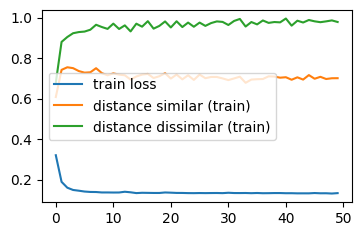

4 ---------------------------------------

classes distribution in train set: (array([0, 1]), array([ 305, 3324]))

classes distribution in test set: (array([0, 1]), array([ 35, 384]))
Epoch 1/50	-	train:  loss=0.31, dist_sim=0.63, dist_dissim=0.74	-	
test:  loss=0.23, dist_sim=0.85, dist_dissim=0.9
Epoch 2/50	-	train:  loss=0.19, dist_sim=0.73, dist_dissim=0.93	-	
test:  loss=0.19, dist_sim=0.88, dist_dissim=0.93
Epoch 3/50	-	train:  loss=0.16, dist_sim=0.72, dist_dissim=0.96	-	
test:  loss=0.17, dist_sim=0.88, dist_dissim=0.93
Epoch 4/50	-	train:  loss=0.15, dist_sim=0.72, dist_dissim=0.97	-	
test:  loss=0.17, dist_sim=0.81, dist_dissim=0.87
Epoch 5/50	-	train:  loss=0.14, dist_sim=0.7, dist_dissim=0.97	-	
test:  loss=0.16, dist_sim=0.83, dist_dissim=0.91
Epoch 6/50	-	train:  loss=0.14, dist_sim=0.69, dist_dissim=0.97	-	
test:  loss=0.16, dist_sim=0.89, dist_dissim=0.95
Epoch 7/50	-	train:  loss=0.14, dist_sim=0.72, dist_dissim=0.99	-	
test:  loss=0.16, dist_sim=0.78, dist_dissim=0.8

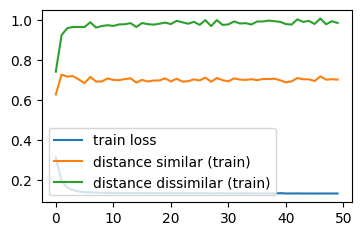

5 ---------------------------------------

classes distribution in train set: (array([0, 1]), array([ 305, 3315]))

classes distribution in test set: (array([0, 1]), array([ 35, 391]))
Epoch 1/50	-	train:  loss=0.34, dist_sim=0.54, dist_dissim=0.63	-	
test:  loss=0.24, dist_sim=0.6, dist_dissim=0.77
Epoch 2/50	-	train:  loss=0.2, dist_sim=0.74, dist_dissim=0.9	-	
test:  loss=0.18, dist_sim=0.6, dist_dissim=0.79
Epoch 3/50	-	train:  loss=0.16, dist_sim=0.75, dist_dissim=0.92	-	
test:  loss=0.16, dist_sim=0.56, dist_dissim=0.78
Epoch 4/50	-	train:  loss=0.15, dist_sim=0.73, dist_dissim=0.91	-	
test:  loss=0.15, dist_sim=0.56, dist_dissim=0.82
Epoch 5/50	-	train:  loss=0.15, dist_sim=0.72, dist_dissim=0.91	-	
test:  loss=0.14, dist_sim=0.65, dist_dissim=0.94
Epoch 6/50	-	train:  loss=0.14, dist_sim=0.75, dist_dissim=0.94	-	
test:  loss=0.14, dist_sim=0.56, dist_dissim=0.83
Epoch 7/50	-	train:  loss=0.14, dist_sim=0.74, dist_dissim=0.94	-	
test:  loss=0.14, dist_sim=0.57, dist_dissim=0.86


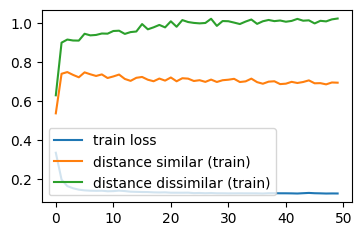

6 ---------------------------------------

classes distribution in train set: (array([0, 1]), array([ 305, 3331]))

classes distribution in test set: (array([0, 1]), array([ 35, 387]))
Epoch 1/50	-	train:  loss=0.32, dist_sim=0.57, dist_dissim=0.65	-	
test:  loss=0.24, dist_sim=0.75, dist_dissim=0.75
Epoch 2/50	-	train:  loss=0.19, dist_sim=0.75, dist_dissim=0.89	-	
test:  loss=0.18, dist_sim=0.75, dist_dissim=0.78
Epoch 3/50	-	train:  loss=0.16, dist_sim=0.73, dist_dissim=0.91	-	
test:  loss=0.17, dist_sim=0.79, dist_dissim=0.83
Epoch 4/50	-	train:  loss=0.15, dist_sim=0.73, dist_dissim=0.94	-	
test:  loss=0.16, dist_sim=0.78, dist_dissim=0.83
Epoch 5/50	-	train:  loss=0.14, dist_sim=0.72, dist_dissim=0.96	-	
test:  loss=0.15, dist_sim=0.76, dist_dissim=0.84
Epoch 6/50	-	train:  loss=0.14, dist_sim=0.68, dist_dissim=0.98	-	
test:  loss=0.15, dist_sim=0.84, dist_dissim=0.91
Epoch 7/50	-	train:  loss=0.13, dist_sim=0.68, dist_dissim=0.99	-	
test:  loss=0.15, dist_sim=0.81, dist_dissim=0

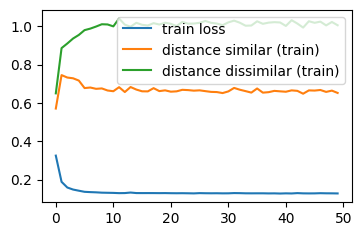

7 ---------------------------------------

classes distribution in train set: (array([0, 1]), array([ 305, 3311]))

classes distribution in test set: (array([0, 1]), array([ 35, 392]))
Epoch 1/50	-	train:  loss=0.33, dist_sim=0.55, dist_dissim=0.61	-	
test:  loss=0.22, dist_sim=0.67, dist_dissim=0.83
Epoch 2/50	-	train:  loss=0.19, dist_sim=0.7, dist_dissim=0.88	-	
test:  loss=0.18, dist_sim=0.75, dist_dissim=0.97
Epoch 3/50	-	train:  loss=0.16, dist_sim=0.72, dist_dissim=0.94	-	
test:  loss=0.16, dist_sim=0.67, dist_dissim=0.9
Epoch 4/50	-	train:  loss=0.15, dist_sim=0.71, dist_dissim=0.94	-	
test:  loss=0.16, dist_sim=0.73, dist_dissim=0.96
Epoch 5/50	-	train:  loss=0.15, dist_sim=0.7, dist_dissim=0.95	-	
test:  loss=0.15, dist_sim=0.74, dist_dissim=0.95
Epoch 6/50	-	train:  loss=0.14, dist_sim=0.69, dist_dissim=0.95	-	
test:  loss=0.15, dist_sim=0.77, dist_dissim=1
Epoch 7/50	-	train:  loss=0.14, dist_sim=0.71, dist_dissim=0.97	-	
test:  loss=0.15, dist_sim=0.83, dist_dissim=1.1
Epo

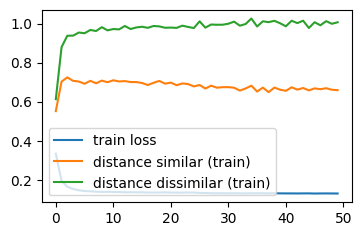

8 ---------------------------------------

classes distribution in train set: (array([0, 1]), array([ 310, 3444]))

classes distribution in test set: (array([0, 1]), array([ 30, 335]))
Epoch 1/50	-	train:  loss=0.32, dist_sim=0.56, dist_dissim=0.65	-	
test:  loss=0.21, dist_sim=0.64, dist_dissim=0.78
Epoch 2/50	-	train:  loss=0.19, dist_sim=0.73, dist_dissim=0.89	-	
test:  loss=0.16, dist_sim=0.58, dist_dissim=0.81
Epoch 3/50	-	train:  loss=0.16, dist_sim=0.73, dist_dissim=0.91	-	
test:  loss=0.15, dist_sim=0.64, dist_dissim=0.86
Epoch 4/50	-	train:  loss=0.15, dist_sim=0.72, dist_dissim=0.94	-	
test:  loss=0.14, dist_sim=0.6, dist_dissim=0.83
Epoch 5/50	-	train:  loss=0.14, dist_sim=0.71, dist_dissim=0.97	-	
test:  loss=0.14, dist_sim=0.6, dist_dissim=0.87
Epoch 6/50	-	train:  loss=0.14, dist_sim=0.7, dist_dissim=0.97	-	
test:  loss=0.13, dist_sim=0.57, dist_dissim=0.85
Epoch 7/50	-	train:  loss=0.13, dist_sim=0.71, dist_dissim=0.97	-	
test:  loss=0.13, dist_sim=0.56, dist_dissim=0.89

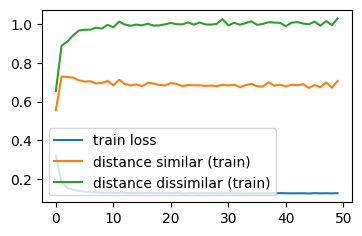

9 ---------------------------------------

classes distribution in train set: (array([0, 1]), array([ 310, 3434]))

classes distribution in test set: (array([0, 1]), array([ 30, 340]))
Epoch 1/50	-	train:  loss=0.33, dist_sim=0.58, dist_dissim=0.68	-	
test:  loss=0.21, dist_sim=0.72, dist_dissim=1.1
Epoch 2/50	-	train:  loss=0.19, dist_sim=0.75, dist_dissim=0.88	-	
test:  loss=0.17, dist_sim=0.8, dist_dissim=1.1
Epoch 3/50	-	train:  loss=0.16, dist_sim=0.76, dist_dissim=0.92	-	
test:  loss=0.14, dist_sim=0.71, dist_dissim=1
Epoch 4/50	-	train:  loss=0.15, dist_sim=0.76, dist_dissim=0.92	-	
test:  loss=0.14, dist_sim=0.72, dist_dissim=0.98
Epoch 5/50	-	train:  loss=0.14, dist_sim=0.77, dist_dissim=0.94	-	
test:  loss=0.14, dist_sim=0.73, dist_dissim=1
Epoch 6/50	-	train:  loss=0.14, dist_sim=0.77, dist_dissim=0.93	-	
test:  loss=0.14, dist_sim=0.69, dist_dissim=0.91
Epoch 7/50	-	train:  loss=0.14, dist_sim=0.75, dist_dissim=0.93	-	
test:  loss=0.14, dist_sim=0.72, dist_dissim=0.96
Epoch

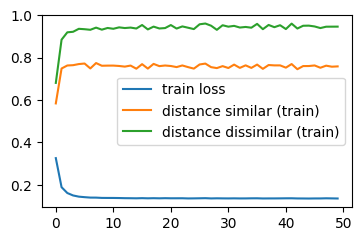

In [38]:
from sklearn.model_selection import KFold
ranking_model_names = ["KNN", "DTree", "DTree2"]
model_types = ["KNN", "DTree", "DTree"]
for name in ranking_model_names:
    predictions[f"MtrL+{name}"] = np.zeros(shape=newY.shape)

i = 0
for train_index, test_index in KFold(n_splits=10, shuffle=True, random_state=0).split(newX):
    print(i, "---------------------------------------")
    # train_index = [j for j in range(X.shape[0]) if i != j]
    # test_index = [i]
    X_train, X_test = newX[train_index], newX[test_index]
    Y_trainr, Y_testr = newY[train_index], newY[test_index]
    Y_trainrn, Y_testrn = Yrn[selected_datasets][train_index], Yrn[selected_datasets][test_index]

    network = nn.Sequential(
        nn.Linear(X.shape[1], 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 8),
        nn.ReLU(),
        nn.Linear(8, 4)
    )
    network.to(device)
    model = MetaModel(network, margin=1, device=device, gamma=1e-2)
    metric_learning_params = {
        "lr": 1e-3,
        "epochs": 50,
        "batch_size": 32
    }
    model.train_metric_learner(
        X_train, Y_trainrn,
        metric_learning_params,
        Xtest=X_test, Ytest=Y_testrn
    )

    plt.figure(figsize=(4, 2.5))
    plt.plot(model.metric_learner.history["train"]["loss"], label="train loss")
    plt.plot(model.metric_learner.history["train"]["distance_similar"], label="distance similar (train)")
    plt.plot(model.metric_learner.history["train"]["distance_dissimilar"], label="distance dissimilar (train)")
    # plt.plot(model.metric_learner.history["test"]["loss"], "--", label="test loss")
    # plt.plot(model.metric_learner.history["test"]["distance_similar"], "--", label="distance similar (test)")
    # plt.plot(model.metric_learner.history["test"]["distance_dissimilar"], "--", label="distance dissimilar (test)")
    plt.legend()
    plt.show()

    Z_train = model.embbed(X_train)
    for k, name in enumerate(ranking_model_names):
        model.ranker = ALL_MODELS[model_types[k]]()
        model.train_ranker(Z_train, Y_trainr if name[-1] != '2' else Y_trainrn)
        predictions[f"MtrL+{name}"][test_index] = model.predict(X_test)
    i += 1

In [60]:
baseline_pairs = {
    "haverage": "manhattan_hamming",
    "fasterpam": "euclidean_hamming",
    "kprototypes": "sqeuclidean_hamming",
}
similarity_pairs = benchmark_results[algorithm][eval_metric].columns
sim_pairs_index = dict(zip(similarity_pairs, range(len(similarity_pairs))))

ndcg_ranks = [1, 3, 5, 10, 15, 20]
n_bests = [1, 3, 5, 10]
ndcg_scores = {
    model_name: {p: np.zeros(newX.shape[0]) for p in ndcg_ranks}
    for model_name in predictions
} #| {'ensemble': {p: np.zeros(meta_X.shape[0]) for p in ndcg_ranks}}

lb_scores = np.zeros(newX.shape[0])
rb_scores = {k: np.zeros(newX.shape[0]) for k in n_bests}
mb_scores = np.zeros(newX.shape[0])
model_scores = {
    model_name: {k: np.zeros(newX.shape[0]) for k in n_bests}
    for model_name in predictions
} #| {'ensemble': {k: np.zeros(len(test_index)) for k in n_bests}}

for name, Y_pred in predictions.items():
    Y_pred = np.array(Y_pred)
    for p in ndcg_ranks:
        ndcg_scores[name][p] = ndcg(newY, Y_pred, p=p)

for name, Y_pred in predictions.items():
    Y_pred = np.array(Y_pred)
    for k in n_bests:
        model_scores[name][k] = np.array(
            [max(y[y > 0][np.argsort(-Y_pred[i][y > 0])[:k]]) for i, y in enumerate(newY)])

for k in n_bests:
    rb_scores[k] = np.array(
        [max(np.random.choice(y[y > 0], k)) for y in newY])

lb_scores = newY[:, sim_pairs_index[baseline_pairs[algorithm]]]
mb_scores = np.array([max(y) for y in newY])

/homedir/adiop/workspace/simrec-for-mdc/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homedir/adiop/workspace/simrec-for-mdc/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


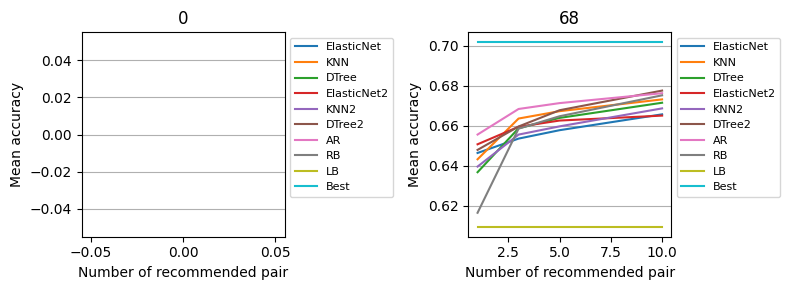

In [61]:
list_indices = [
    [i for i, y in enumerate(newY) if (max(y[y>0]) - np.quantile(y[y>0], 0.))/max(y[y>0]) < 0.], #test_index[i] in base_datasets and 
    [i for i, y in enumerate(newY) if (max(y[y>0]) - np.quantile(y[y>0], 0.))/max(y[y>0]) >= 0.]
]
rows, cols = 1, len(list_indices)
plt.figure(figsize=(cols*4, rows*3))
subplot_num = 1
for indices in list_indices:
    scores = {k:v for k, v in model_scores.items()} 
    scores["RB"] = rb_scores
    scores["LB"] = lb_scores
    scores["Best"] = mb_scores

    y = {key: [] for key in scores}

    for name, score in scores.items():
        for k in n_bests:
            u = score[indices] if name in ["LB", "Best"] else score[k][indices]
            y[name].append(np.mean(u))

    plt.subplot(rows, cols, subplot_num)
    for name, values in y.items():
        plt.plot(n_bests, values, label=name)
    plt.ylabel("Mean accuracy")
    plt.xlabel("Number of recommended pair")
    # plt.ylim((0.67, 0.9))
    plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1))
    plt.grid(axis="y")
    plt.title(len(indices))
    subplot_num += 1
plt.tight_layout()
# plt.savefig("output/mean_acc2.svg")
plt.show()

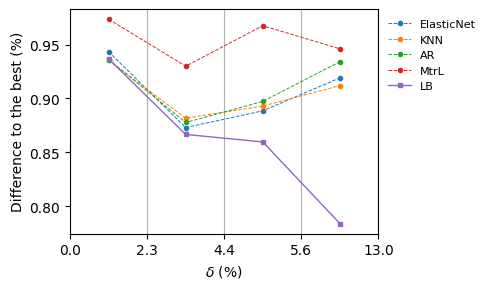

In [60]:
baselines = ["LB"]
k = 1
plt.figure(figsize=(5, 3))
# if j == 0:
#     ax = plt.subplot(2, 1, 1)
# else:
#     ax = plt.subplot(2, 1, 2)
# res = results[algo]

best_scores = mb_scores
y = {}
l = [(np.std(y[y>0])) for i, y in enumerate(Y)]
x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 5)])

x[0] -= 1e-4
diff = 0.025
list_indices = [
    [xr < np.std(y[y>0]) <= x[r+1] for i, y in enumerate(Y)]
    for r, xr in enumerate(x[:-1])
] #

for model_name, scores in model_scores.items():
    y[model_name] = []
    for i, indices in enumerate(list_indices):
        # new_ind = [val and lb_scores[j] > 0 for j, val in enumerate(indices)]
        v = np.mean(((scores[k])/best_scores)[indices])
        y[model_name].append(v)

y["LB"] = []
for i, indices in enumerate(list_indices):
    v = np.mean(((lb_scores)/best_scores)[indices])
    y["LB"].append(v)

n_bar = len(y)
w = 0.8/n_bar
z = np.arange(len(x))
i = 0
max_ = np.zeros(len(list_indices))
min_ = np.ones(len(list_indices))*100
for model_name, values in y.items():
    max_ = np.maximum(max_, values)
    min_ = np.minimum(min_, values)
    # plt.plot(z[:-1]+0.5, values, "--", linewidth=0.7, label=None, alpha=1 if i<6 else 0.7, zorder=10)
    # plt.scatter(z[:-1]+0.5, values, label=model_name, s=[10*np.log(sum(val)) for val in list_indices], alpha=1 if i<6 else 0.7, zorder=10)
    plt.plot(z[:-1]+0.5, values, "--o" if model_name not in baselines else "-s", linewidth=0.7 if model_name not in baselines else 1, label=model_name, markersize=3, zorder=10)
    i += 1

for ind, val in enumerate(list_indices):
    if ind >= 1:
        plt.annotate(f"{max_[ind]:.2g}%", (z[ind]+0.5, max_[ind]+1), fontsize=8, ha="center", va="top")

# plt.bar(x[1:]-diff/2, [50 for _ in diff], width=diff[0], zorder=0, label=None, color="None", edgecolor="gray")

plt.xlim((z[0], z[-1]))
plt.ylabel("Difference to the best (%)")
plt.xticks(z, [f"{max(0, val*100):.1f}" for val in x])
# plt.ylim((min(min_)-1, max(max_)+1))
plt.grid(axis="x")
plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1), frameon=False)
plt.xlabel("$\delta$ (%)")

# if j == 0:
#     plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1), frameon=False)
# if j == 1: 
#     plt.xlabel("$\delta$ (%)")
# j += 1
# plt.title(names[algo], y=0.83)

plt.tight_layout()
# if savedir is not None:
#     plt.savefig(os.path.join(savedir, f"diff_best_delta_{algo}_{k}.pdf"))
plt.show()